In [274]:
#---IMPORT STATEMENTS---
import MySegments
import MyVisualiser
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit as SSS
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA, NMF, FastICA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold

from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
from sklearn.externals import joblib
import datetime

#RBF Parameters heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from os import mkdir
from os import listdir
from os.path import isfile, join

mypath = 'S1 VV GLCM'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

 #Get labelled data
sc = MySegments.SegmentCollection(folder = mypath, segments_path=onlyfiles, labels_path = 'labels.csv', classes_path='class_names.csv')
idx,X,y = sc.get_labelled()

X = VarianceThreshold().fit_transform(X,y)
feature_names = sc.feature_names

MemoryError: 

In [270]:
# Create a temporary folder to store the transformers of the pipeline
now = datetime.datetime.now()
print('started at:',now.strftime("%Y-%m-%d_%H-%M"))

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

out = pd.DataFrame()
out['feature'] = feature_names
out = out.set_index('feature')

selection_methods = [chi2, mutual_info_classif,f_classif]
labels = ['chi2','mut_info','ANOVA']
scalers = [MinMaxScaler(), RobustScaler(), RobustScaler()]  

cv=0
for train_index, test_index in skf.split(X, y):
  #  print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    cv=cv+1

    for selection_method, label, scaler in zip(selection_methods, labels, scalers):
        
        #print(cv, label)
        selector = SelectKBest(selection_method, k='all')
        selector.fit(scaler.fit_transform(X_train), y_train)

        mask = selector.get_support() #list of booleans
        features = [] # The list of your K best features
        scores = []

        for bool, feature, score in zip(mask, feature_names, selector.scores_):
                features.append(feature)
                scores.append(score)

        df = pd.DataFrame()
        df['feature'] = features
        df = df.set_index('feature')
        #df[label + '_' + str(cv)] = np.array(scores)
        df[label + '_' + str(cv)] = np.array(scores)/(np.max(np.array(scores))*skf.get_n_splits(X, y))
       # df = df.sort_values(by='score_' + str(cv), ascending=False)        
        
        out = pd.merge(out, df, left_index=True, right_index=True)

started at: 2018-05-01_16-47


In [271]:
#compute mean and std per feature selection method
for selection_method,label in zip(selection_methods,labels):
    #print(str(label) + '_mean')
    filter_col = [col for col in out if col.startswith(label)]      
    out[str(label + '_mean')] = out[filter_col].sum(axis=1)
    out[str(label + '_std')] = out[filter_col].std(axis=1)
    out[str(label + '_rank')] = out[str(label + '_mean')].rank(ascending=False)
#remove individual cv results
for cv in range(1,skf.get_n_splits(X,y)+1):
    filter_col = [col for col in out if col.endswith('_'+str(cv))]
    out = out.drop(filter_col,axis=1)

In [272]:
out2 = pd.DataFrame()
out2['feature'] = feature_names
out2 = out2.set_index('feature')

for selection_method,label in zip(selection_methods,labels):
    #print(str(label) + '_mean')
    filter_col = [col for col in out if col.startswith(label)] 
    
    df = out.sort_values(by = str(label + '_mean'), ascending = False)[filter_col]#.head(10)
    out2 = pd.merge(out2, df, left_index=True, right_index=True, how='outer')

out2 = out2.fillna(0)
filter_col = [col for col in out if col.endswith('mean')]
out2['all_mean'] = out2[filter_col].sum(axis=1)

filter_col = [col for col in out if col.endswith('rank')]
out2['avg_rank'] = out2[filter_col].sum(axis=1).divide(len(selection_methods))
out2 = out2[out2['avg_rank']>0]

out2['all_rank'] = out2['avg_rank'].rank(ascending=True)
out2 = out2.sort_values(by='all_mean', ascending = False)


out2 = out2[(out2['all_rank']>0)&(out2['all_rank']<=15)].sort_values(by='all_rank', ascending = False)


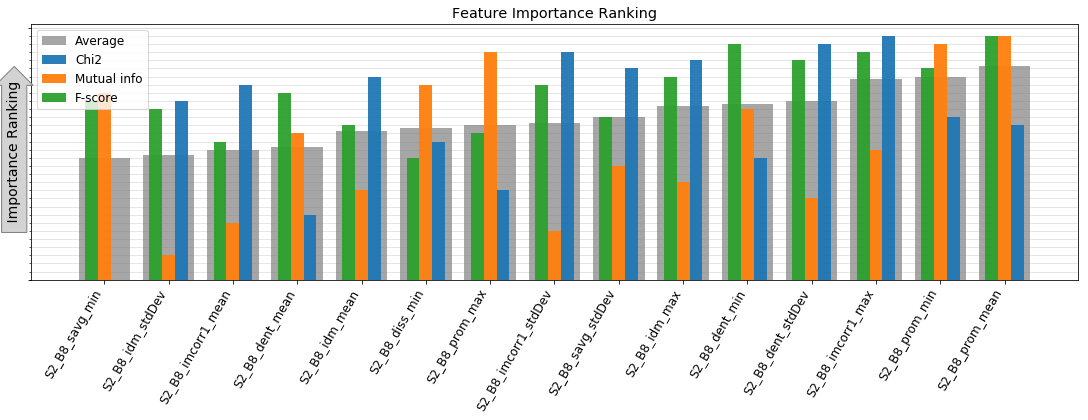

In [273]:
#vertical plot
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

matplotlib.rcParams.update({'font.size': 12})

maxval = 0
if out2['chi2_rank'].max() >= maxval:
    maxval = out2['chi2_rank'].max()
if out2['mut_info_rank'].max() >= maxval:
    maxval = out2['mut_info_rank'].max()
if out2['ANOVA_rank'].max() >= maxval:
    maxval = out2['ANOVA_rank'].max()

out2 = out2.fillna(0)

ind = np.arange(len(out2['avg_rank'].values))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))

rects4 = ax.bar(ind, out2['avg_rank'].apply(lambda x: maxval-x).values, width*4, color='Gray', alpha = 0.7, label='Average')
rects1 = ax.bar(ind + width, out2['chi2_rank'].apply(lambda x: maxval-x).values, width, alpha = 0.95, label='Chi2')
rects2 = ax.bar(ind, out2['mut_info_rank'].apply(lambda x: maxval-x).values, width,  alpha = 0.95, label='Mutual info')
rects3 = ax.bar(ind - width, out2['ANOVA_rank'].apply(lambda x: maxval-x).values, width,  alpha = 0.95, label='F-score')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Feature Importance Ranking')
ax.set_xticks(ind)
ax.set_xticklabels(out2.index.values, rotation=60,ha="right")
#ax.set_xlabel('Ranking')
#ax.set_xticks(np.arange(start=int(maxval),stop=0, step=-1,dtype=int))
ax.set_yticks([maxval,0])
#ax.set_ylabel('Importance')
ax.set_yticks(np.arange(maxval),minor=True)
#ax.set_yticklabels(['least important', 'most important'], rotation=90)
ax.grid(b=True, axis='y', which='major', linestyle='-', alpha=0.6)
#ax.grid(b=True, axis='y', which='major', linestyle='-', alpha=0.6)
ax.grid(b=True, axis='y', which='minor', linestyle='-', alpha=0.4)
#plt.minorticks_on()
#ax.tick_params(axis='x',which='minor',bottom='off')
#ax.tick_params(axis='y',which='major',bottom='off')
ax.set_axisbelow(True)


bbox_props = dict(boxstyle="rarrow,pad=0.4", fc="lightgrey", ec="gray", lw=1)
t = ax.text(-7*width, maxval/2, " Importance Ranking", ha="center", va="center", rotation=90,
            size=14,
            bbox=bbox_props)

ax.get_yaxis().set_ticklabels([])

ax.legend(loc='best')
plt.tight_layout()
plt.savefig('Results/Feature Selection Rankings/'+ mypath+ '.png')
out2.to_csv('Results/Feature Selection Rankings/'+ mypath+'.csv')

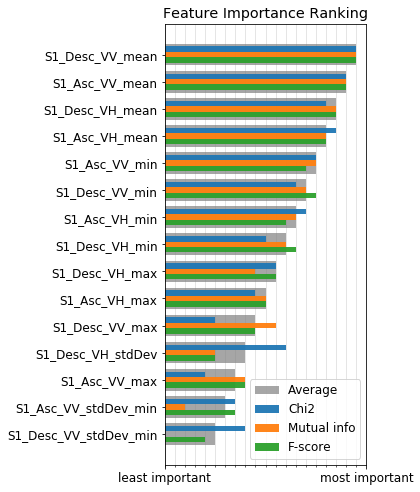

In [255]:
#Horizontal plot

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

matplotlib.rcParams.update({'font.size': 12})

out2 = out2.fillna(0)

ind = np.arange(len(out2['all_rank'].values))  # the x locations for the groups
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(6,7))

maxval = 0
if out2['chi2_rank'].max() >= maxval:
    maxval = out2['chi2_rank'].max()
if out2['mut_info_rank'].max() >= maxval:
    maxval = out2['mut_info_rank'].max()
if out2['ANOVA_rank'].max() >= maxval:
    maxval = out2['ANOVA_rank'].max()

rects4 = ax.barh(ind, out2['all_rank'].apply(lambda x: maxval-x).values, width*4, color='Gray', alpha = 0.7, label='Average')
rects1 = ax.barh(ind + width, out2['chi2_rank'].apply(lambda x: maxval-x).values, width, alpha = 0.95, label='Chi2')
rects2 = ax.barh(ind, out2['mut_info_rank'].apply(lambda x: maxval-x).values, width,  alpha = 0.95, label='Mutual info')
rects3 = ax.barh(ind - width, out2['ANOVA_rank'].apply(lambda x: maxval-x).values, width,  alpha = 0.95, label='F-score')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Feature Importance Ranking')
ax.set_yticks(ind)
ax.set_yticklabels(out2.index.values, rotation=0)
#ax.set_xlabel('Ranking')
#ax.set_xticks(np.arange(start=int(maxval),stop=0, step=-1,dtype=int))
ax.set_xticks([0,maxval])
ax.set_xticks(np.arange(maxval),minor=True)
ax.set_xticklabels(['least important', 'most important'])
ax.grid(b=True, axis='x', which='major', linestyle='-', alpha=0.6)
#ax.grid(b=True, axis='y', which='major', linestyle='-', alpha=0.6)
ax.grid(b=True, axis='x', which='minor', linestyle='-', alpha=0.4)
#plt.minorticks_on()
ax.tick_params(axis='y',which='minor',bottom='off')
ax.set_axisbelow(True)



ax.legend(loc='best')
#plt.gcf().subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.savefig(mypath+ '.png')
out2.to_csv(mypath +'.csv')

In [210]:
out2['all_rank'] = out2['all_rank'].rank(ascending=True)

In [211]:
out2

,feature,chi2_mean,chi2_std,chi2_rank,mut_info_mean,mut_info_std,mut_info_rank,ANOVA_mean,ANOVA_std,ANOVA_rank,all_mean,all_rank,top_rank
0,S2_B2_mean,0.379887,0.002939,29.0,0.939103,3.738902e-03,6.0,0.407483,3.807997e-03,10.0,1.726473,7.5,7.5
1,S2_B6_max,0.420497,0.004743,17.0,0.857790,3.283926e-03,12.0,0.336999,2.327265e-03,17.0,1.615286,7.5,7.5
2,S1_Desc_VV_maxcorr_mean,0.381284,0.005580,28.0,0.908809,3.534650e-03,10.0,0.451225,3.055071e-03,5.0,1.741318,6.0,6.0
3,S2_B8_mean,0.394193,0.004338,25.0,0.956151,4.188966e-03,4.0,0.516767,5.625442e-03,4.0,1.867111,4.5,4.5
4,S2_B3_mean,0.402261,0.004164,19.0,0.942996,2.807680e-03,5.0,0.421580,3.859167e-03,8.0,1.766838,4.5,4.5
5,S2_B5_mean,0.389351,0.010429,26.0,0.984325,1.315212e-03,2.0,0.727632,1.652987e-03,2.0,2.101308,3.0,3.0
6,S1_Desc_VV_stdDev_svar_mean,0.400419,0.004955,21.0,0.973478,4.243458e-03,3.0,0.558727,5.764238e-03,3.0,1.932624,2.0,2.0
7,S2_B6_mean,0.688422,0.009406,6.0,1.000000,1.962616e-17,1.0,1.000000,2.403703e-17,1.0,2.688422,1.0,1.0
